# Телеком 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

## Загрузка данных

In [1]:
#!pip install phik==0.11.1
#!pip install -U scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
import re
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

RS = 100423

In [2]:
try:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

**Contract**

In [3]:
print(contract.duplicated().sum())
display(contract.head())
contract.info()
contract.describe()

0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


**Personal**

In [4]:
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Internet**

In [5]:
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Phone**

In [6]:
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В датасетах Contract и Personal содержатся 7043 объекта, в Internet - 5517, в Phone - 6361. Во всех датасетах отсутствуют пропуски, присутствуют бинарные признаки и нарушен змеиный стиль в названиях столбцов.

Дубликатов в Contract нет, наличие их в других датасетах проверять нецелесообразно.

`TotalCharges` имеет не верный тип данных.

## Подготовка данных

Объединим датасеты и приведем названия столбцов к змеиному стилю.

In [7]:
telecom = contract.merge(personal, 
                      how='left', on='customerID').merge(internet, 
                      how='left', on='customerID').merge(phone, 
                      how='left', on='customerID')  
        
telecom = telecom.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())

telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Из `end_date` извлечем таргет и заполним пропуски датой выгрузки данных - 01.02.2020 г.

Затем изменим тип данных `begin_date` и `end_date` на datetime и вычислим новый признак - продолжительность пользования услугами.

In [8]:
telecom['churn'] = (telecom['end_date'] != 'No').astype(int)

telecom.loc[(telecom['end_date'] == 'No'),'end_date'] = '2020-02-01 00:00:00'

telecom['begin_date'] = pd.to_datetime(telecom['begin_date'],format= "%Y/%m/%d")
telecom['end_date'] = pd.to_datetime(telecom['end_date'],format= "%Y/%m/%d")

telecom['duration'] = (telecom['end_date'] - telecom['begin_date']).dt.days

telecom.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Посмотрим, из-за чего у `total_charges` неправильный тип данных. Пропусков там нет, вероятно вместо них могут быть пробелы.

In [9]:
telecom.loc[telecom['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Видим, что все договоры с пробелами в `total_charges` были заключены в дату выгрузки данных. Заменим пробелы на соответствующие значения `monthly_charges` и изменим тип данных.

Также заменим тип данных для `senior_citizen` и заполним пропуски в других столбцах заглушкой 'NA'.

In [10]:
telecom.loc[telecom['total_charges'] == ' ', 'total_charges'] = telecom.loc[telecom['total_charges'] == ' ', 'monthly_charges']
telecom['total_charges'] = pd.to_numeric(telecom['total_charges'], errors='coerce')

telecom['senior_citizen'] = telecom['senior_citizen'].astype(object)

NA = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
     'streaming_tv', 'streaming_movies', 'multiple_lines']
    
for n in NA:
    telecom[n] = telecom[n].fillna('NA')
    
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

## Исследовательский анализ

Посмотрим, насколько признаки коррелируют между собой.

In [11]:
telecom = telecom.set_index('customer_id')
phik_overview = telecom.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn', 'duration']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration
begin_date,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.01,0.05,0.47,...,0.19,0.46,0.50,0.50,0.46,0.42,0.43,0.47,0.45,0.98
end_date,0.55,1.00,0.29,0.06,0.17,0.17,0.22,0.02,0.09,0.18,...,0.12,0.17,0.24,0.23,0.15,0.19,0.20,0.25,1.00,0.40
type,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,...,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.09,0.63
paperless_billing,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,...,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.08,0.03
payment_method,0.46,0.17,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,...,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.21,0.35
monthly_charges,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,...,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.23,0.39
total_charges,0.77,0.22,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,...,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.30,0.85
gender,0.01,0.02,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
senior_citizen,0.05,0.09,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,...,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.09,0.06
partner,0.47,0.18,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,...,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.45


Для наглядности изобразим матрицу на тепловой карте.

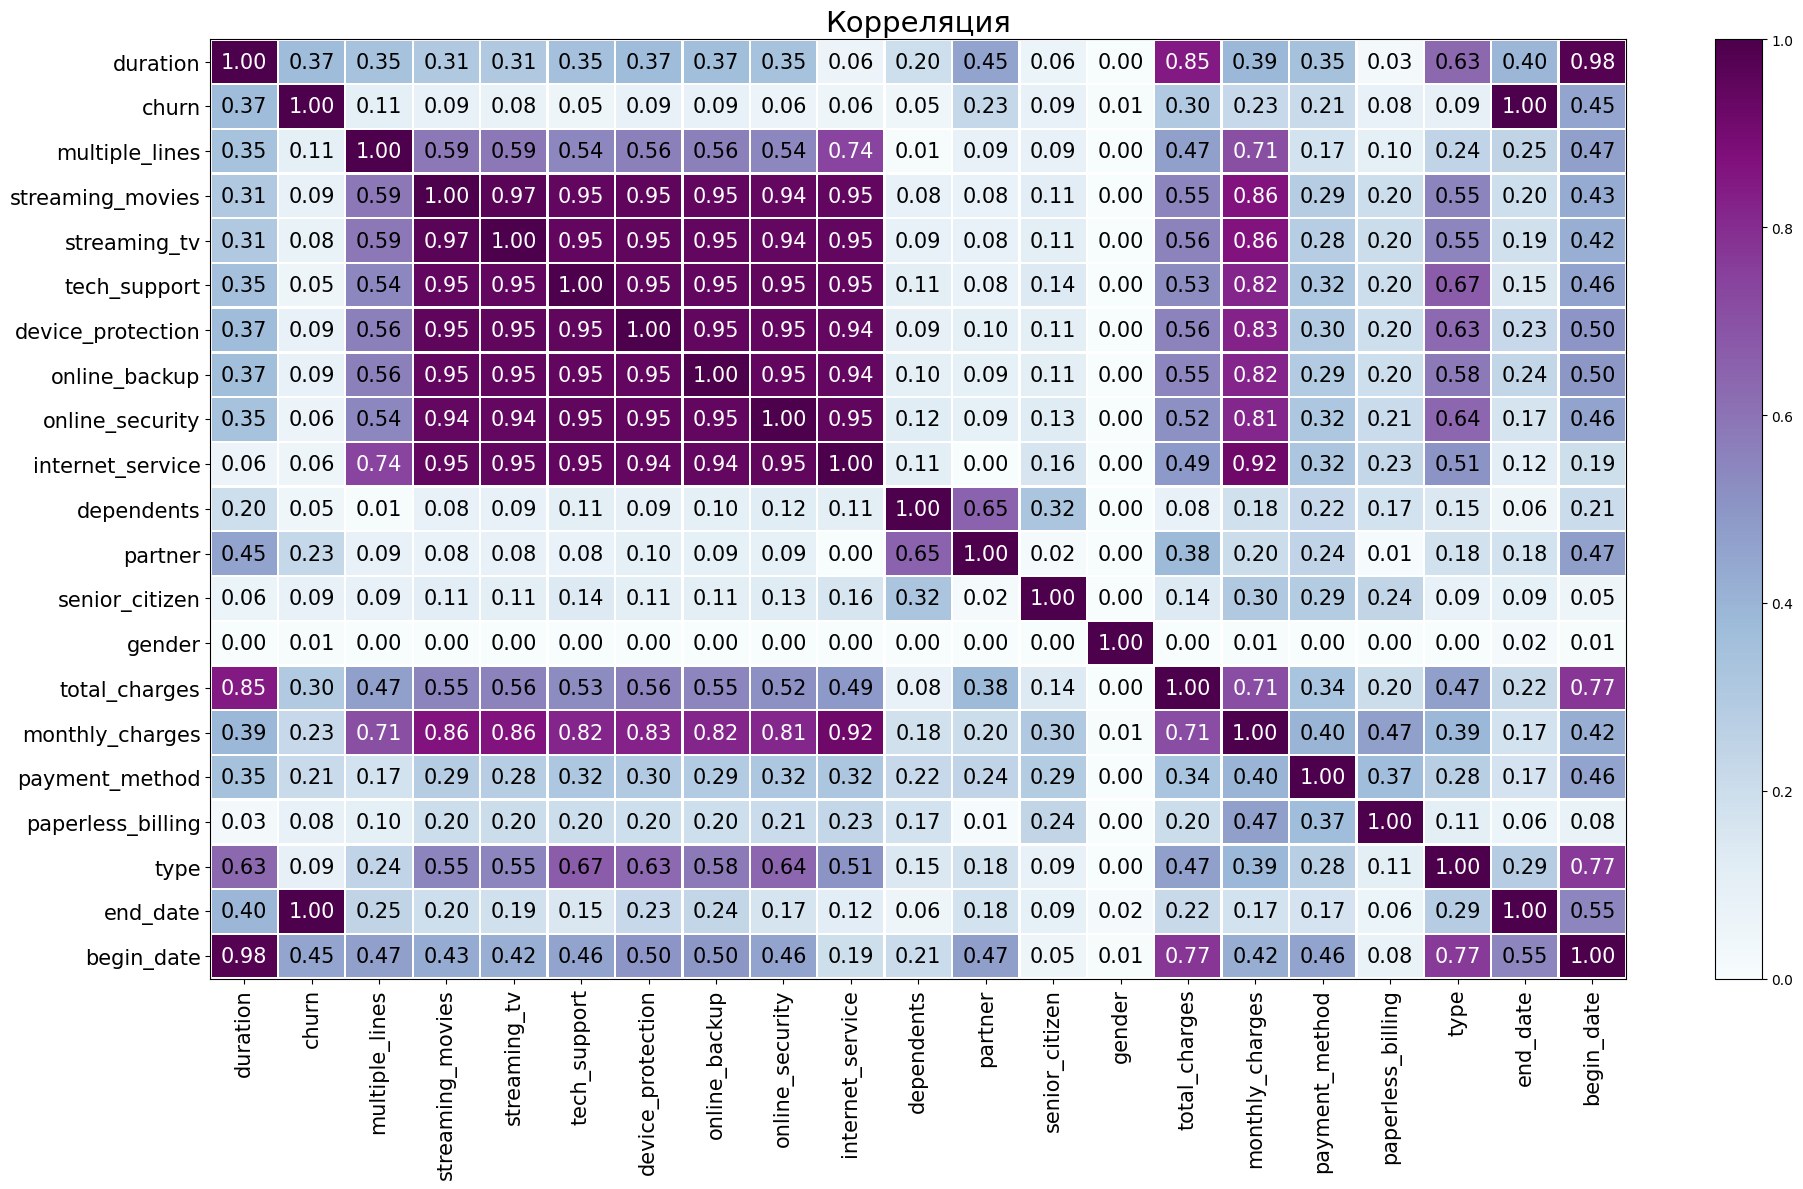

In [12]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="BuPu", 
                        title=r"Корреляция", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

Больше всего с другими признаками коррелирует `monthly_charges`. Видим корреляцию `total_charges` и `duration`, `begin_date`.

Также можем наблюдать сильную корреляцию всех признаков из датасета Internet между собой, а также их среднюю корелляцию с `multiple_lines` и `type`. 

Меньше всего с другими признаками коррелируют `gender`, `senior_citizen`, `partner`, `dependents`.

**Распределение признаков**

Посмотрим на распределение целевого признака.

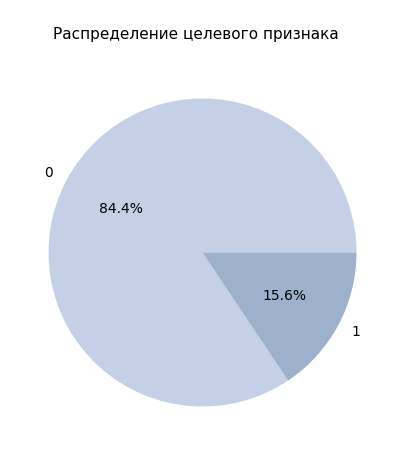

In [13]:
churn = telecom['churn'].value_counts()

fig = plt.figure(figsize = (5, 5))
fig.suptitle('\nРаспределение целевого признака', fontsize=11)
plt.pie(churn, labels = churn.index, autopct='%.1f%%', colors=['#c5d0e6', '#9db1cc'])
plt.show();

Ушедших клиентов около 15% - на первый взгляд не так много.

Теперь изучим распределение остальных признаков, для этого разделим их на численные и категориальные.

In [14]:
num = telecom[['duration', 'monthly_charges', 'total_charges']]
cat = telecom.drop(['churn', 'duration', 'monthly_charges', 'total_charges', 'begin_date', 'end_date'], axis = 1)

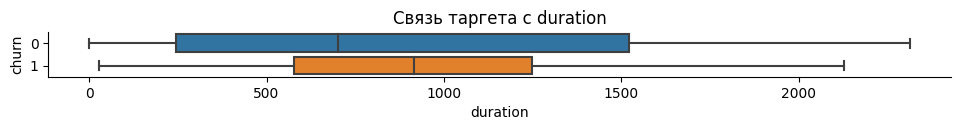

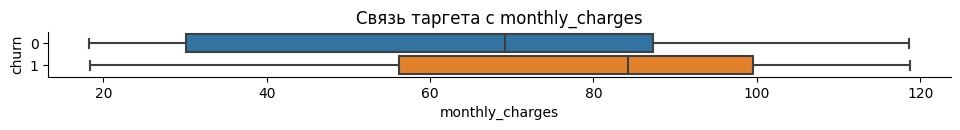

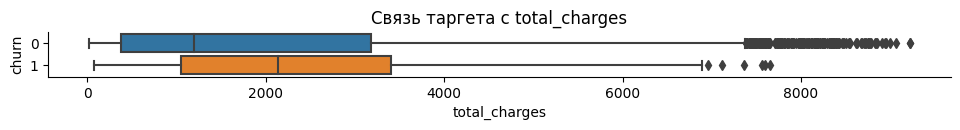

In [15]:
for n in num:    
    g = sns.catplot(y='churn', x=n, kind="box", data=telecom, orient='h')
    g.fig.set_figwidth(10)
    g.fig.set_figheight(0.5)
    plt.title(f'Связь таргета с {n}')
    plt.show();

Видим, что у ушедших клиентов и месячные и общие расходы выше, чем у оставшихся.

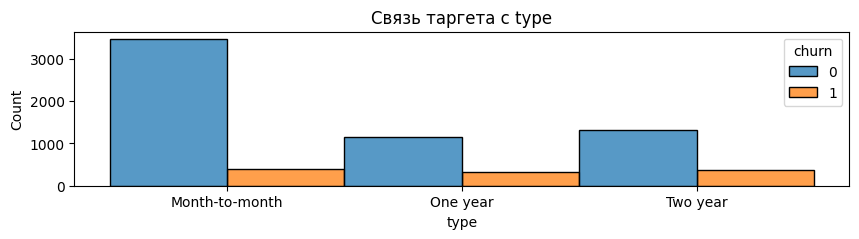

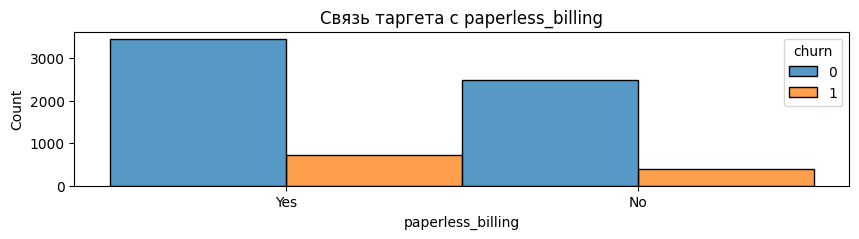

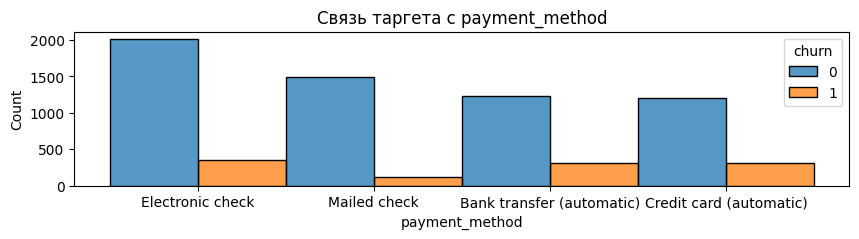

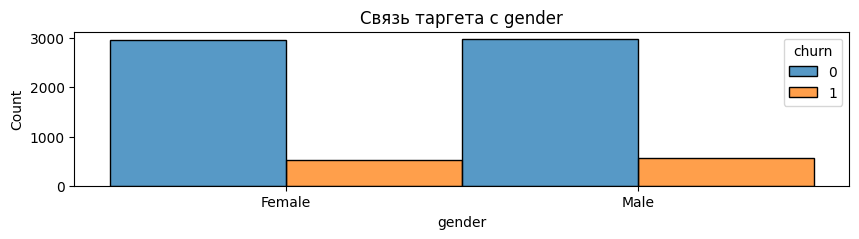

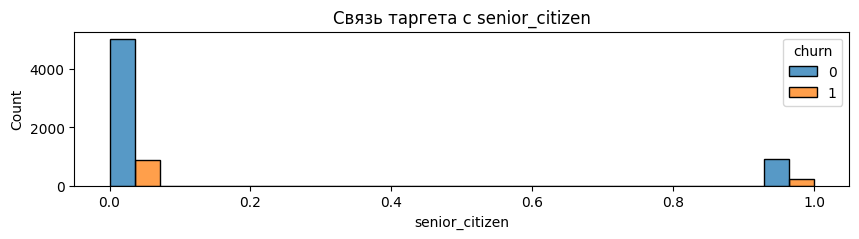

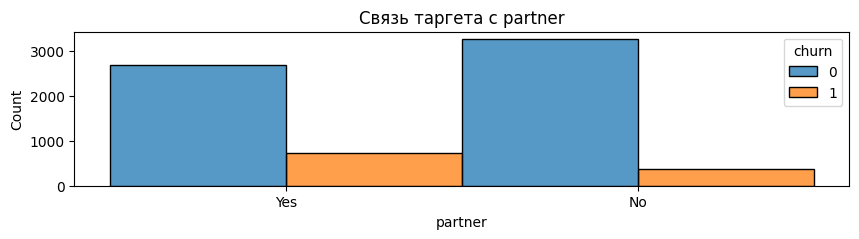

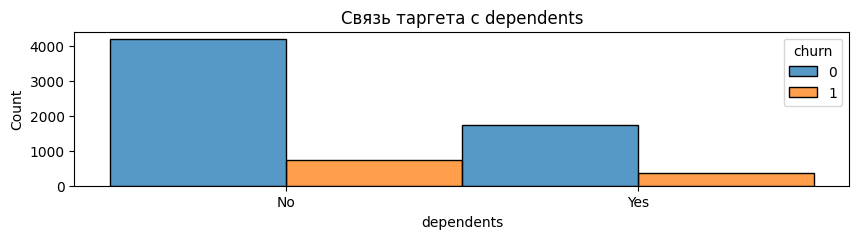

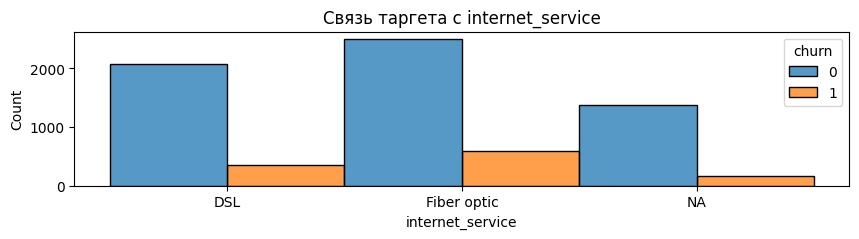

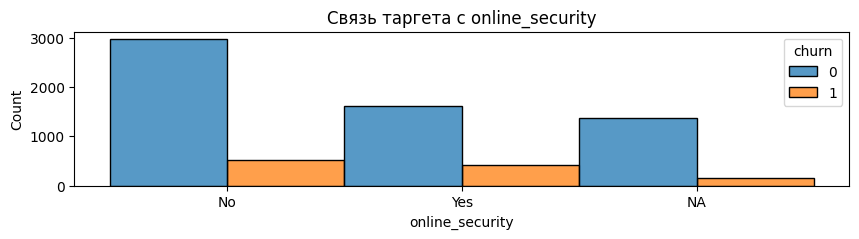

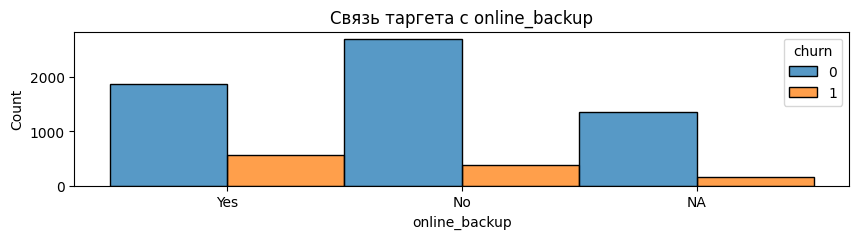

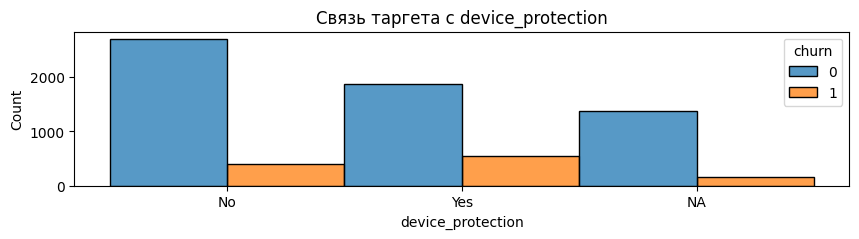

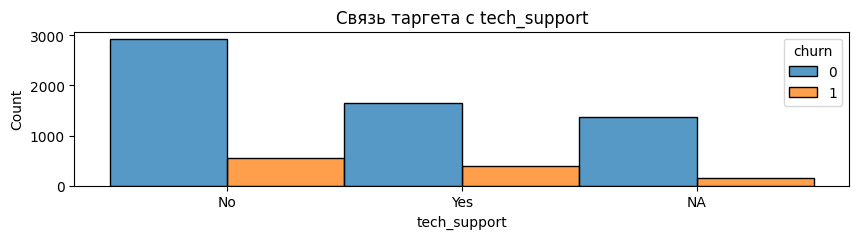

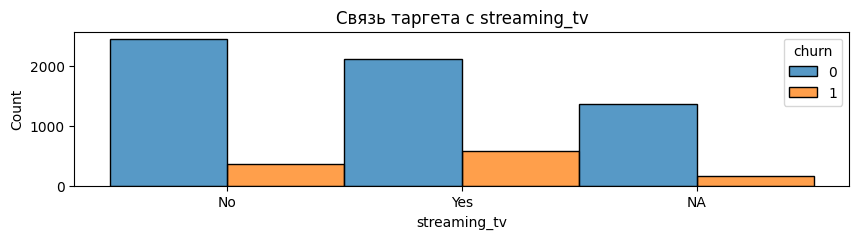

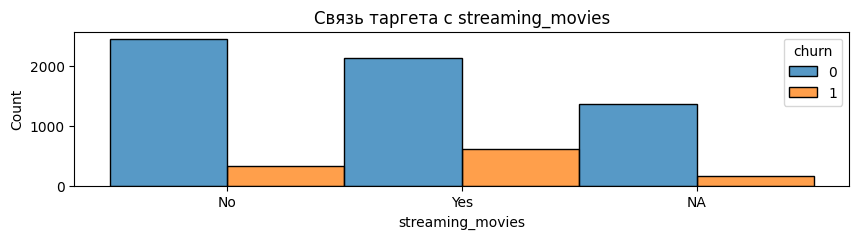

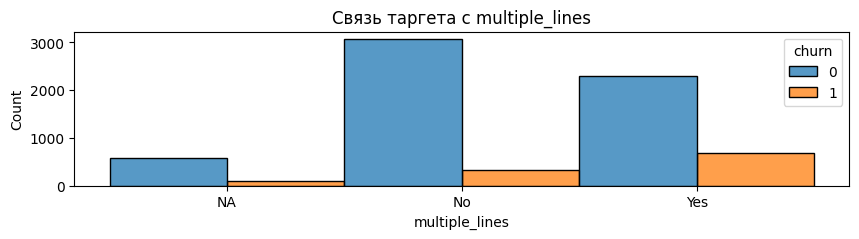

In [16]:
for c in cat:
    plt.figure(figsize=(10,2))
    sns.histplot(data=telecom, x=c, hue='churn', multiple='dodge')
    plt.title(f'Связь таргета с {c}')
    plt.show();

Видим, что пол и тип оплаты практически не влиет на факт ухода клиента.

При этом, большинство ушедших клиентов пользовались электронными платежными документами и электронными чеками, у них были супруги, но не было иждивенцев и песионного статуса. Также они выбирали оптическое волокно и наличие возможности ведение параллельных линий во время звонка.

Из дополнительных услуг они пользовались антивирусом, облачным хранилищем, стриминговым телевидением и каталогом фильмов.

## Обучение моделей

**Подготовка признаков**

Удалим лишние столбцы - `begin_date` и `end_date`.

Затем разделим данные на обучающую и тестовую выборки.

In [17]:
telecom_final = telecom.drop(['begin_date', 'end_date'], axis=1).reset_index(drop=True)
telecom_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

In [18]:
target = telecom_final['churn']
features = telecom_final.drop('churn', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                              target, test_size = 0.25, 
                                                                              random_state = RS)

print('Размер обучающей выборки:', 'признаки:', features_train.shape, 'целевой признак:', target_train.shape, sep='\n')
print('Размер тестовой выборки:', 'признаки:', features_test.shape, 'целевой признак:', target_test.shape, sep='\n')

Размер обучающей выборки:
признаки:
(5282, 18)
целевой признак:
(5282,)
Размер тестовой выборки:
признаки:
(1761, 18)
целевой признак:
(1761,)


Закодируем и стандартизируем категориальные признаки для логистичесской регрессии.

In [19]:
categorical = ['type', 'paperless_billing', 'payment_method', 'gender','senior_citizen', 'partner', 'dependents', 
              'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 
               'streaming_tv', 'streaming_movies','multiple_lines']

In [20]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(features_train_ohe[categorical])
features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(features_train_ohe[categorical])
features_test_ohe[ohe.get_feature_names_out()] = ohe.transform(features_test_ohe[categorical])
features_train_ohe = features_train_ohe.drop(categorical, axis=1)
features_test_ohe = features_test_ohe.drop(categorical, axis=1)

print('Размер признаков обучающей выборки:', features_train_ohe.shape)
print('Размер признаков тестовой выборки:', features_test_ohe.shape)
features_train_ohe.head()

Размер признаков обучающей выборки: (5282, 44)
Размер признаков тестовой выборки: (1761, 44)


,monthly_charges,total_charges,duration,type_Month-to-month,type_One year,type_Two year,paperless_billing_No,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),...,tech_support_Yes,streaming_tv_NA,streaming_tv_No,streaming_tv_Yes,streaming_movies_NA,streaming_movies_No,streaming_movies_Yes,multiple_lines_NA,multiple_lines_No,multiple_lines_Yes
1704,99.75,402.99,123,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1147,60.25,180.75,92,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6662,39.65,1863.55,1432,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3667,96.55,2548.92,730,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5552,20.25,445.50,671,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [21]:
features_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1704 to 1879
Data columns (total 44 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   monthly_charges                           5282 non-null   float64
 1   total_charges                             5282 non-null   float64
 2   duration                                  5282 non-null   int64  
 3   type_Month-to-month                       5282 non-null   float64
 4   type_One year                             5282 non-null   float64
 5   type_Two year                             5282 non-null   float64
 6   paperless_billing_No                      5282 non-null   float64
 7   paperless_billing_Yes                     5282 non-null   float64
 8   payment_method_Bank transfer (automatic)  5282 non-null   float64
 9   payment_method_Credit card (automatic)    5282 non-null   float64
 10  payment_method_Electronic check  

In [23]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

**Логистическая регрессия**

In [24]:
%%time

param_grid = {'C': [1,10,100],
              'solver':['liblinear', 'lbfgs'],
              'max_iter': [100, 200]}

model = LogisticRegression(random_state=RS, class_weight='balanced')
lr = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv = 5)
lr.fit(features_train_ohe, target_train)

best_roc_auc = lr.best_score_.round(2)

print(lr.best_params_)
print('AUC-ROC:', best_roc_auc)

{'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
AUC-ROC: 0.77
CPU times: total: 2.55 s
Wall time: 2.44 s


**LGBM**

In [25]:
features_train[categorical] = features_train[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

In [26]:
%%time

param_grid = {'n_estimators': [50, 100, 200],
             'learning_rate': [0.01, 0.1, 0.3],
             'max_depth': (2, 20, 2),
             'boosting_type': ['gbdt', 'dart']}

model = LGBMClassifier(random_state=RS, class_weight = 'balanced')
lgbm = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
lgbm.fit(features_train, target_train)

auc_roc = lgbm.best_score_.round(2)

print(lgbm.best_params_)
print('AUC-ROC:', auc_roc.round(2))

{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200}
AUC-ROC: 0.89
CPU times: total: 1.41 s
Wall time: 16.6 s


**Значимость признаков**

Лучший результат показала модель LGBM. Посмотрим, какие признаки оказались наиболее важными для нее.

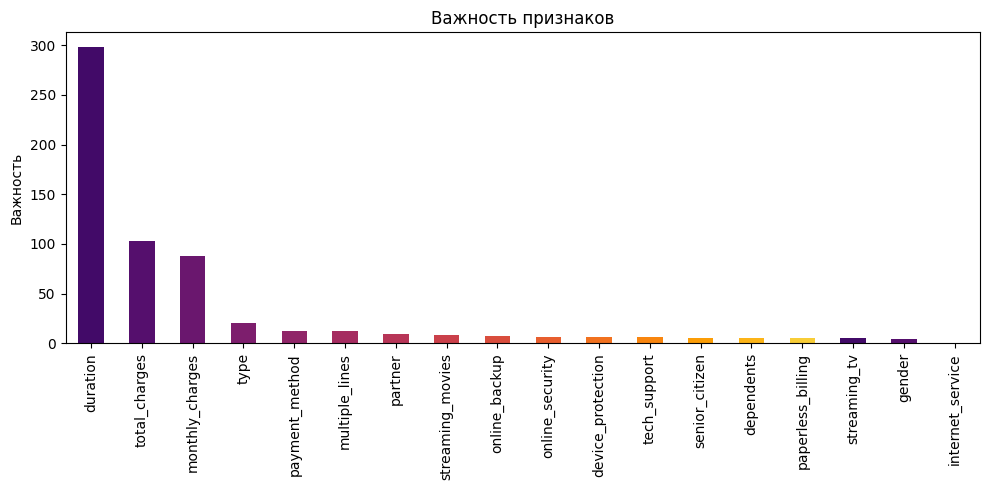

In [28]:
color = cm.inferno_r(np.linspace(.8, .12, 15))

model = lgbm.best_estimator_.fit(features_train, target_train)
importance = pd.Series(model.feature_importances_,
                         features_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
importance.plot.bar(ax=ax, color = color)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Больше всего на факт ухода клиента влияет время пользования услугами. Также большое значение имеют ежемесячные и общие траты.

**Тестирование модели**

In [29]:
lgbm_test = LGBMClassifier(random_state=RS, **lgbm.best_params_, n_jobs=-1)

auc_roc = roc_auc_score(target_test, lgbm.best_estimator_.predict_proba(features_test)[:, 1])

print('AUC-ROC:', auc_roc.round(2))

AUC-ROC: 0.89


Построим график ROC-кривой для модели LGBM.

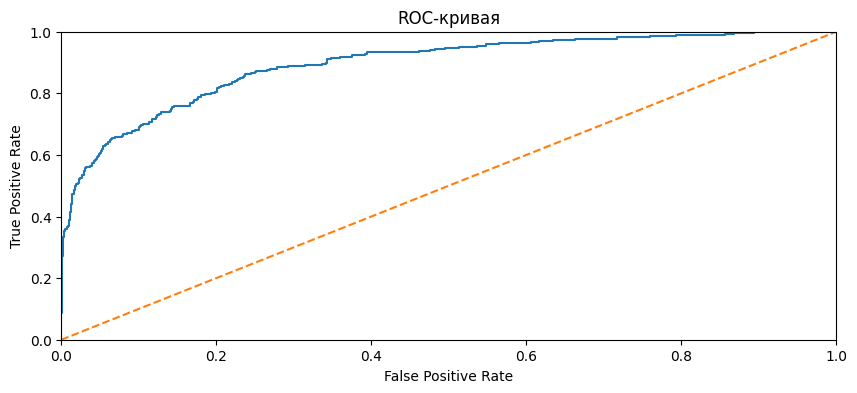

In [30]:
fpr, tpr, thresholds = roc_curve(target_test, lgbm.best_estimator_.predict_proba(features_test)[:, 1])

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

**Матрица ошибок**

Построим матрицу ошибок для сопоставления предсказаний и реальных значений таргета.

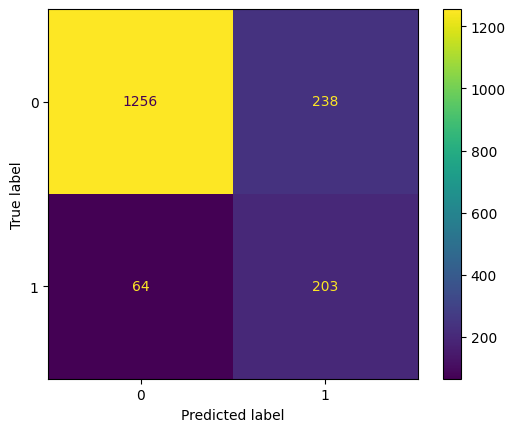

In [31]:
pred = lgbm.best_estimator_.predict(features_test)

cm = confusion_matrix(target_test, pred, labels=lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
disp.plot();

Модель хорошо предсказывает факт того, что клиент остался. При этом выдает ложноположительные ответы чаще, чем истинно положительные.

## Вывод

Для подбора модели, предсказывающей отток клиентов банка, были обучены 2 модели: логистическая регрессия и LGBM.

Для оценки предсказаний была использована метрика AUC-ROC.

При подборе гиперпараметров наилучший результат показала LGBM со следующими гиперпараметрами:

- boosting_type: gbdt
- learning_rate: 0.3 
- max_depth: 2
- n_estimators: 200

При проверке на тестовой выборке модель достигла AUC-ROC = 0.89, а значит сможет с достаточной точностью спрогнозировать отток клиентов.

Наибольшее влияние на вероятность ухода клиента из банка из имеют время пользования услугами, а также ежемесячные и общие траты.

## Отчет

1.Были выполнены следующие пункты плана:
- Подготовка данных - объединены выборки, добавлены новые признаки (`churn` и `duration`), обработаны пропуски, изменены типы данных.
- Исследовательский анализ - проведен анализ на мультиколлинеарность признаков и корреляцию с таргетом, данные проверены на дисбаланс классов.
- Построение, обучение и проверка моделей - построены и обучены модели логистической регресии и LGBM, проведена оценка результатов, выбрана лучшая модель и проверена на тестовой выборке.
- Отчет по решению - сделаны выводы по результатам и предложена модель для решения задачи.

2.Основные трудности возникли с кодировкой признаков и избеганием утечки целевого признака. Для того, чтобы это не произошло, кодировка и транформирование данных проводилось после разделения датасета на выборки. Также необходимо было потратить время на то, чтобы вспомнить или узучить как работают некоторые инструменты.

3.Ключевые шаги в решении задачи:
- Выделение таргета и создание дополнительных признаков
- Исследовательский анализ данных
- Обучение моделей и анализ результатов

4.Для обучения модели использовались все признаки, кроме `begin_date` и `end_date`. В рамках предобработки были заполнены пропуски, изменен тип данных. Кодировка и стандартизация данных для модели LGBM не требовалась.

5.По результатам анализа итоговой моделью была выбрана LGBM с AUC-ROC = 0.89 и следующими гиперпараметрами:
- boosting_type: gbdt
- learning_rate: 0.3 
- max_depth: 2
- n_estimators: 200.